In [1]:
# save files
fullproc_r = '/Users/jnaiman/LMM_Figure_Parsing/resources/' # for words/names

# extra fonts (downloaded) -- these mimic old-timey fonts
extra_font_dir = '/Users/jnaiman/Dropbox/wwt_image_extraction/FullProcess_resources/fonts/' # see this dir for README for how these were installed
extra_font_search_dir = '/opt/anaconda3/envs/FullProcess/fonts/' # check env here for font to be there

# where to save the figures that are created
fake_figs_dir = '/Users/jnaiman/Dropbox/wwt_image_extraction/Paper_JCDL2025/example_hists/'

# save diagnostic plot with all items labeled?
save_diagnostic_plot = True

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2 as cv
import pickle
import pandas as pd
#import string
from glob import glob
from mpl_toolkits.axes_grid1 import make_axes_locatable
from PIL import ImageColor
import json
import os
from copy import deepcopy
import copy

from utils.metric_utils.utilities import isRectangleOverlap

import time

import matplotlib as mpl
import os
os.environ["PATH"] += os.pathsep + '/Library/TeX/texbin'
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = r'\usepackage{amsmath} \usepackage{amssymb}' #for \text command

# written libs -- will update locally
from utils.synthetic_fig_utils import subset_by_percent, \
 get_nrows_and_ncols, normalize_params_prob, get_ticks, get_titles_or_labels, \
 get_font_info

from utils.plot_utils import get_contour_plot, get_histogram_plot, \
   get_line_plot, get_scatter_plot, make_plot, colorbar_mods#, get_line_plot

from utils.text_utils import get_popular_nouns, get_inline_math

# create a bunch of fake figures
from utils.synthetic_fig_utils import normalize_params_prob
from utils.plot_parameters import plot_types_params, panel_params, \
  title_params, xlabel_params, colorbar_params, \
  ylabel_params, aspect_fig_params, dpi_params, tight_layout_params, \
  fontsizes, base

from utils.data_utils import get_data, NumpyEncoder

import utils.distribution_utils

from utils.plot_utils import markers
marker_sizes = np.arange(0,10)+1
line_list_thick = np.arange(1,10)

use_uniques = True # use unique inlines
verbose = True

from sys import path
path.append('/Library/TeX/texbin/')

# debug
from importlib import reload

# for seed
from sys import maxsize as maxint

import warnings
warnings.filterwarnings("error")

In [3]:
# get fonts -- see "cnn_create_synthetic_ticks" in FullProcess
dfont = pd.read_csv(fullproc_r + 'fonts.csv')

# check that location is there
drop_names = []
for fl in dfont['font location']:
    if not os.path.exists(fl):
        drop_names.append(False)
    else:
        drop_names.append(True)

font_names = dfont.loc[drop_names]['font name'].values

# # for plot styles
# plot_styles = plt.style.available

# plot_types_qa = ['line', 'scatter', 'histogram']

plot_styles = ['default']

In [4]:
# stats for doing calculations
stats = {'minimum':np.min, 'maximum':np.max, 'median':np.median, 'mean':np.mean}

# some things to try
aspect_cut = {'min':0.3, 'max':4.0}

In [5]:
# get popular words for titles/axis
popular_nouns = get_popular_nouns(fullproc_r + 'data/')

# get inline math formulas
inlines = get_inline_math(fullproc_r,
                          recreate_inlines=False,
                         use_uniques=use_uniques)

16253 343492
shape of output= (5097, 5)
shape of output= (36332, 5)
number of inlines =  33201


## Update plotting params

### Plot type params

In [6]:
plot_params = plot_types_params.copy()

In [7]:
# only histograms for this one

# probability of getting a scatter plot
plot_params['scatter']['prob'] = 0
# probability of getting a line
plot_params['line']['prob'] = 0
# prob of getting a contour plot
plot_params['contour']['prob'] = 0
# prob of getting an image of the sky
plot_params['image of the sky']['prob'] = 0

In [8]:
# prob for getting a histogram
plot_params['histogram']['prob'] = 1


linestyles_hist = ['-'] # only use a subset of the linestyles

plot_params['histogram'] = plot_params['histogram'].copy()

# no horizontal plots
plot_params['histogram']['horizontal prob'] = 0.0

# random distributions
plot_params['histogram']['distribution']['random']['prob'] = 0

# gaussian mixture model
plot_params['histogram']['distribution']['gmm']['prob'] = 1
plot_params['histogram']['distribution']['gmm']['nclusters'] = {'min': 1, 'max': 5}
plot_params['histogram']['distribution']['gmm']['nsamples'] = {'min': 10, 'max': 50}

# linear distributions prob
plot_params['histogram']['distribution']['linear']['prob'] = 1

### Other parameters

In [9]:
panel_params['number prob']['median'] = 4 # smaller, usually use 4-ish, 1 for debugging
panel_params['number prob']['max'] = 25 # 2 for debugging, 25 for typical run

In [10]:
# for ease of things, lets not do equations here
title_params['equation']['prob'] = 0.0 # probability any word will be equation
xlabel_params['equation']['prob'] = 0.0 # probability any word will be equation
ylabel_params['equation']['prob'] = 0.0 # probability any word will be equation

Renormalize all probabilities:

In [11]:
# reload for debug
import utils.synthetic_fig_utils
reload(utils)
reload(utils.synthetic_fig_utils)
from utils.synthetic_fig_utils import normalize_params_prob

plot_params_out, panel_params, \
  title_params, xlabel_params, \
  ylabel_params = normalize_params_prob(plot_params.copy(), panel_params, 
                                        title_params, xlabel_params, 
                                        ylabel_params, colorbar_params)

plot_params_out

title_params capatilize did not add to 1! total = 1.2999999999999998
renormalizing...
now:  {'none': 0.07692307692307694, 'first': 0.3846153846153847, 'all': 0.5384615384615385}
xlabel_params capatilize did not add to 1! total = 1.2999999999999998
renormalizing...
now:  {'none': 0.07692307692307694, 'first': 0.3846153846153847, 'all': 0.5384615384615385}
ylabel_params capatilize did not add to 1! total = 1.2999999999999998
renormalizing...
now:  {'none': 0.07692307692307694, 'first': 0.3846153846153847, 'all': 0.5384615384615385}
colorbar_params capatilize did not add to 1! total = 1.2999999999999998
renormalizing...
now:  {'none': 0.07692307692307694, 'first': 0.3846153846153847, 'all': 0.5384615384615385}
plot_types_params['scatter']['color bar']['location probs'] did not add to 1! total = 0.8500000000000001
renormalizing...
now:  {'right': 0.588235294117647, 'left': 0.058823529411764705, 'top': 0.2941176470588235, 'bottom': 0.058823529411764705}
plot_types_params['contour']['color b

{'line': {'prob': 0,
  'npoints': {'min': 10, 'max': 11},
  'line thick': {'min': 1, 'max': 5},
  'nlines': {'min': 2, 'max': 3},
  'xmin': -10000,
  'xmax': 10000,
  'ymin': -10000,
  'ymax': 10000,
  'prob same x': 0.1,
  'markers': {'prob': 0.5, 'size': {'min': 1, 'max': 20}},
  'error bars': {'elinewidth': {'min': 1, 'max': 5},
   'x': {'prob': 0.25, 'size': {'min': 0.01, 'max': 0.1}},
   'y': {'prob': 0.25, 'size': {'min': 0.01, 'max': 0.1}}},
  'distribution': {'random': {'prob': 0.3333333333333333},
   'linear': {'prob': 0.3333333333333333,
    'intersect': (-100, 100),
    'slope': (-5, 5),
    'noise': (0, 0.25)},
   'gmm': {'prob': 0.3333333333333333,
    'histogram as line': {'prob': 0.25, 'factor': 1000},
    'nclusters': {'min': 1, 'max': 20},
    'nsamples': {'min': 10, 'max': 500},
    'cluster std': {'min': -2, 'max': 0.5},
    'noise': {'min': 0.05, 'max': 0.25}}}},
 'histogram': {'prob': 1,
  'npoints': {'min': 10, 'max': 10000},
  'nbins': {'min': 1, 'max': 100},
  '

### Run the thing

In [12]:
# Set a seed if you want a reproducible thing
seed_outer = np.random.randint(maxint)
#seed_outer = 7526304181034464103
seed_outer = 6700012876856450103

print('seed_outer =',seed_outer)
rng_outer = np.random.default_rng(seed_outer)

seed_outer = 6700012876856450103


In [13]:
# "Inner" seed -- for things like distributions and whatnot
seed = np.random.randint(maxint)
#seed = 2870146871786070273
seed = 7067533564274193147
print('seed = ', seed)
# based on seed, make random number generator, see: https://numpy.org/doc/2.2/reference/random/generator.html
rng = np.random.default_rng(seed)
condition_overlap_xticklabels = True

seed =  7067533564274193147


In [14]:
# set some things to keep standard across images

tight_layout = True

color_map = 'Blues' #rng_outer.choice(plt.colormaps())

plot_style = 'default' #rng_outer.choice(plot_styles)

npanels, panel_style, nrows, ncols = 1, 'square', 1, 1 #get_nrows_and_ncols(panel_params, rng=rng_outer)

aspect_fig = 0.9

dpi =  300 # int(rng_outer.uniform(low=dpi_params['min'], high=dpi_params['max']))

In [15]:
# use the "fixed" RNG outer
# get all font stuffs
title_fontsize, colorbar_fontsize, xlabel_fontsize, ylabel_fontsize, \
    xlabel_ticks_fontsize, ylabel_ticks_fontsize, \
                        csfont = get_font_info(fontsizes, font_names, rng=rng_outer)

In [16]:
def make_base_plot(plot_style, color_map, dpi, nrows, ncols, 
                   base=5, verbose=True, tight_layout = True):
    plt.close('all')
    plt.style.use(plot_style)
    plt.set_cmap(color_map) 
    figsize = (base*ncols*aspect_fig, base*nrows) # w,h
    if verbose: print('figsize (w,h) =', figsize)

    if tight_layout:
        fig = plt.figure(figsize=figsize, dpi=dpi,layout='tight')
    else:
        fig = plt.figure(figsize=figsize, dpi=dpi)

    axes = []
    for i in range(nrows):
        for j in range(ncols):
            iplot = (i*nrows) + j
            ax = fig.add_subplot(nrows, ncols, iplot + 1)
            axes.append(ax)


    # #### create placeholder axes -- I think this is now obsoluete and should be updated (JPN)
    # axes = np.empty((nrows,ncols),dtype='object')

    # if npanels == 1:
    #     axes = [axes]
    #     plot_inds = [(0,0)] # i,j
    # else: # flatten, for now
    #     # create inds
    #     if len(axes.shape) > 1: # 2d
    #         ashape = np.array(axes.shape).copy()
    #     else:
    #         ashape = [nrows, ncols]
    #     plot_inds = np.empty(shape=(ashape[0], ashape[1],2), dtype=int)
    #     for i in range(ashape[0]):
    #         for j in range(ashape[1]):
    #             plot_inds[i,j][0] = i
    #             plot_inds[i,j][1] = j
    #     plot_inds = plot_inds.reshape((ashape[0]*ashape[1],-1))
    #     axes = axes.flatten()
    return fig, axes #, axes, plot_inds

In [17]:
choices = []; probs = []
for k,v in plot_params_out.items():
    choices.append(k)
    probs.append(v['prob'])

plot_type = rng.choice(choices, p=probs)
plot_type

np.str_('histogram')

In [18]:
# def try_something(var1, **kwargs):
#     for k,v in kwargs.items():
#         if 'var1' in k:
#             var1 = v

#     print('var1 is:', var1)

In [19]:
#try_something(var1 = 'bob')

In [20]:
# #setattr(someobject, key, value)
# # setattr(var2, 3.0)

# class Histogram():
#     def __init__(self):
#         self.rwidth = None
#         self.elinewidth = None

# hist = Histogram()

In [21]:
# for k,v in hist.__dict__.items():
#     print(k,v)

In [22]:
distribution_type = 'gmm'
xmin, xmax = -1, 1 # for now

# now specific for *this plot*
plot_params_here = plot_params_out.copy()

plot_params_here['histogram']['xmin'] = xmin
plot_params_here['histogram']['xmax'] = xmax

plot_params_here['histogram']['distribution']['gmm']['nclusters'] = {'min': 1, 'max': 1}
plot_params_here['histogram']['distribution']['gmm']['nsamples'] = {'min': 10000, 'max': 10000}
#plot_params_here['histogram']['distribution']['gmm']['xmin'] = xmin # are these even used??
#plot_params_here['histogram']['distribution']['gmm']['xmax'] = xmax # are these even used??

dist_params = plot_params_here[plot_type]['distribution'] 

In [31]:
dist_params

{'random': {'prob': 0.0},
 'linear': {'prob': 0.5,
  'intersect': (-100, 100),
  'slope': (-5, 5),
  'noise': (0, 0.25)},
 'gmm': {'prob': 0.5,
  'xmin': -10000,
  'xmax': 10000,
  'ymin': -10000,
  'ymax': 10000,
  'nclusters': {'min': 5, 'max': 5},
  'nsamples': {'min': 10000, 'max': 10000},
  'cluster std': {'min': -1, 'max': 1.5},
  'noise': {'min': 0.05, 'max': 0.25}}}

In [23]:
import utils.distribution_utils
reload(utils.distribution_utils)

data_for_plot = get_data(plot_params_here[plot_type],
                plot_type=plot_type,
                        distribution=distribution_type, 
                        rng=rng)
data_for_plot

{'xs': array([0.82055095, 0.82375684, 0.82172528, ..., 0.86056228, 0.87080305,
        0.83310381]),
 'ys': [],
 'xerrs': True,
 'data params': {'nsamples': 10000,
  'nclusters': 1,
  'centers': array([[0.85855147]]),
  'cluster_std': array([0.14265167]),
  'noise level': 0.1049343528642392}}

figsize (w,h) = (1.8, 2)


<Figure size 640x480 with 0 Axes>

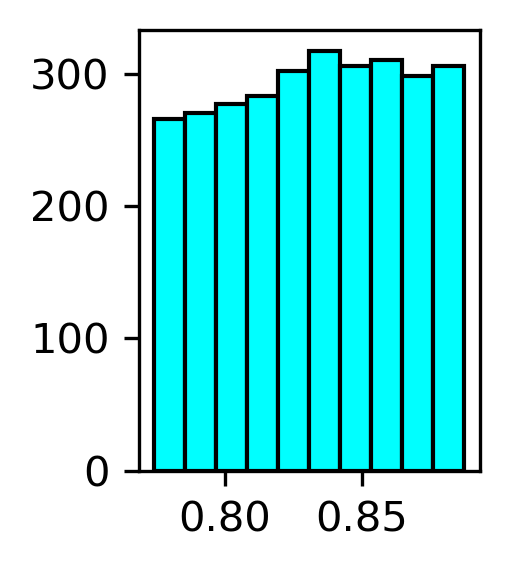

In [24]:
import utils.plot_utils
reload(utils.plot_utils)
from utils.plot_utils import make_plot

fig, axes = make_base_plot(plot_style, color_map, dpi, nrows, ncols, 
                   base=2, verbose=True, tight_layout = tight_layout)

data_from_plot, ax = make_plot(plot_params_here[plot_type], data_for_plot, 
                        axes[0], plot_type=plot_type, linestyles=linestyles_hist, 
                        rng=rng, 
                        barcolor='cyan', linecolor=(0,0,0), hasErr = False, lthick=1, nbins=10, rwidth=1.0)

In [25]:
data_from_plot

{'data': (array([266., 270., 277., 283., 302., 317., 306., 310., 298., 306.]),
  array([0.77411229, 0.78546148, 0.79681067, 0.80815986, 0.81950905,
         0.83085824, 0.84220744, 0.85355663, 0.86490582, 0.87625501,
         0.8876042 ]),
  <BarContainer object of 10 artists>),
 'plot params': {'linethick': 1,
  'linestyles': np.str_('-'),
  'bar color': 'cyan',
  'edge color': [array([0, 0, 0])],
  'orientation': 'vertical',
  'rwidth': 1.0,
  'nbins': 10}}

In [26]:
data_for_plot

{'xs': array([0.82055095, 0.82375684, 0.82172528, ..., 0.86056228, 0.87080305,
        0.83310381]),
 'ys': [],
 'xerrs': True,
 'data params': {'nsamples': 10000,
  'nclusters': 1,
  'centers': array([[0.85855147]]),
  'cluster_std': array([0.14265167]),
  'noise level': 0.1049343528642392}}

Loop for several distributions and save:

In [27]:
from utils.histogram_plot_qa_utils import q_nbars_hist_plot_plotnums, q_colors_hist_plot_plotnums, \
  q_colorlines_hist_plot_plotnums, q_linethickness_hists, q_barpoints_bars, q_stats_hists, \
  q_errorbars_existance_lines, q_errorbars_size_histogram, q_distribution_hists, \
  q_linear_equation_hists, q_gmm_equation_hists

In [35]:
#plot_params_loop['histogram']['distribution']['gmm']

figsize (w,h) = (1.8, 2)
figsize (w,h) = (1.8, 2)
figsize (w,h) = (1.8, 2)
figsize (w,h) = (1.8, 2)
figsize (w,h) = (1.8, 2)
figsize (w,h) = (1.8, 2)
figsize (w,h) = (1.8, 2)
figsize (w,h) = (1.8, 2)
figsize (w,h) = (1.8, 2)
figsize (w,h) = (1.8, 2)
figsize (w,h) = (1.8, 2)
figsize (w,h) = (1.8, 2)
figsize (w,h) = (1.8, 2)
figsize (w,h) = (1.8, 2)
figsize (w,h) = (1.8, 2)
figsize (w,h) = (1.8, 2)
figsize (w,h) = (1.8, 2)
figsize (w,h) = (1.8, 2)
figsize (w,h) = (1.8, 2)
figsize (w,h) = (1.8, 2)
figsize (w,h) = (1.8, 2)
figsize (w,h) = (1.8, 2)
figsize (w,h) = (1.8, 2)
figsize (w,h) = (1.8, 2)
figsize (w,h) = (1.8, 2)
figsize (w,h) = (1.8, 2)
figsize (w,h) = (1.8, 2)
figsize (w,h) = (1.8, 2)
figsize (w,h) = (1.8, 2)
figsize (w,h) = (1.8, 2)
figsize (w,h) = (1.8, 2)
figsize (w,h) = (1.8, 2)
figsize (w,h) = (1.8, 2)
figsize (w,h) = (1.8, 2)
figsize (w,h) = (1.8, 2)
figsize (w,h) = (1.8, 2)
figsize (w,h) = (1.8, 2)
figsize (w,h) = (1.8, 2)
figsize (w,h) = (1.8, 2)
figsize (w,h) = (1.8, 2)


<Figure size 640x480 with 0 Axes>

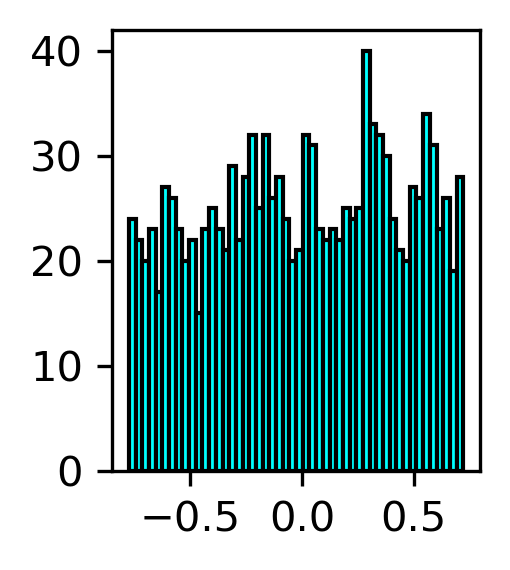

In [36]:
nclusters = [1, 2, 3, 4, 5]

cluster_std = {'min':0.001, 'max':1.0}

plot_json = []

ntrials = 10

for n in range(ntrials):
    for nclust in nclusters:
        plot_params_loop = plot_params_here.copy()
        plot_params_loop['histogram']['distribution']['gmm']['nclusters'] = {'min': nclust, 'max': nclust}
        plot_params_loop['histogram']['distribution']['gmm']['cluster std'] = cluster_std
        data_for_plot = get_data(plot_params_loop[plot_type],
                        plot_type=plot_type,
                                distribution=distribution_type, 
                                rng=rng)
        pltjson = {}
        pltjson['nclusters'] = nclust
        pltjson['data for plot'] = data_for_plot.copy()

        fig, axes = make_base_plot(plot_style, color_map, dpi, nrows, ncols, 
                    base=2, verbose=True, tight_layout = tight_layout)

        data_from_plot, ax = make_plot(plot_params_loop[plot_type], data_for_plot, 
                                axes[0], plot_type=plot_type, linestyles=linestyles_hist, 
                                rng=rng, 
                                barcolor='cyan', linecolor=(0,0,0), hasErr = False, lthick=1, nbins=50, rwidth=1.0)
        pltjson['data from plot'] = data_from_plot.copy()

        # save image
        fig.savefig(fake_figs_dir + 'nclust_' + str(nclust) + '_trial' + str(n) + '.pdf')


        #plot_json.append(pltjson.copy())

In [29]:
fake_figs_dir

'/Users/jnaiman/Dropbox/wwt_image_extraction/Paper_JCDL2025/example_hists/'